<a href="https://colab.research.google.com/github/nik1806/Semantic-segmentation/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [1]:
from torchvision import transforms
from torchvision.datasets import Cityscapes
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from datasets.custom_transforms import decode_segmap, unNormalize

### Dataset reader 

In [2]:
from datasets import cityscapes

In [3]:
# data directory path
data_dir = '../datasets/cityscapes/'
base_size = 288
crop_size = 256

In [4]:
# dataset readers
dst_train = cityscapes.CityscapesSegmentation(crop_size, base_size, root=data_dir, split='train')
dst_val = cityscapes.CityscapesSegmentation(crop_size, base_size, root=data_dir, split='val')

Found 2975 train images
Found 500 val images


### Dataloader

In [5]:
bs = 10
cls_num = 19
#Dataloaders
train_loader = DataLoader(dst_train, batch_size=bs, shuffle=True)
val_loader = DataLoader(dst_val, batch_size=bs,shuffle=False)

### Model

In [6]:
from models.networkT2 import R2UNet

In [7]:
device = torch.device("cuda:7")
model = R2UNet(in_channels=3,n_classes=cls_num).to(device)

### Hyper parameters

In [8]:
epochs = 50
lr = 2e-4
wdk = 6e-4 #earlier 1e-4

In [9]:
from torch.optim import Adam
criterion = torch.nn.CrossEntropyLoss(size_average=True, ignore_index=255)
optimizer = Adam(model.parameters(), lr, (0.9, 0.999),  eps=1e-08, weight_decay=wdk) 

/opt/conda/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


### Training model

In [12]:
from utils.learn import train_val_loop

loss_train = []
loss_val = []

# perform loops
loss_train, loss_val = train_val_loop(model, epochs, train_loader, val_loader, optimizer, 
                                      criterion, loss_train, 2, bs, device)

Epoch0, iter0, running loss: 0.5897863864898681
Epoch0, iter60, running loss: 0.24232878821795104
Epoch0, iter120, running loss: 0.18672556921470262
Epoch0, iter180, running loss: 0.16387982299314677
Epoch0, iter240, running loss: 0.14966228777442236
Epoch0, Training loss: 1.4035083947565732
Epoch0, Validation loss: 1.1094875121116639
Epoch1, iter0, running loss: 0.1179932713508606
Epoch1, iter60, running loss: 0.10353513956069946
Epoch1, iter120, running loss: 0.09921447117466572
Epoch1, iter180, running loss: 0.09499822252363131
Epoch1, iter240, running loss: 0.09125017057563259
Epoch1, Training loss: 0.8919520323108506
Epoch1, Validation loss: 1.0944360625743865
Epoch2, iter0, running loss: 0.10805047750473022
Epoch2, iter60, running loss: 0.07827447779843065
Epoch2, iter120, running loss: 0.07936340511337785
Epoch2, iter180, running loss: 0.07908054255978178
Epoch2, iter240, running loss: 0.07904149909731759
Epoch2, Training loss: 0.7863523356066454
Epoch2, Validation loss: 0.67631

Epoch24, iter0, running loss: 0.034669166803359984
Epoch24, iter60, running loss: 0.04322169559900878
Epoch24, iter120, running loss: 0.04107355725420408
Epoch24, iter180, running loss: 0.04149223082796645
Epoch24, iter240, running loss: 0.04104346789388736
Epoch24, Training loss: 0.4082392307635922
Epoch24, Validation loss: 0.8784882980585098
Epoch25, iter0, running loss: 0.026056572794914246
Epoch25, iter60, running loss: 0.04214801287553349
Epoch25, iter120, running loss: 0.04076593558896672
Epoch25, iter180, running loss: 0.040088315176371056
Epoch25, iter240, running loss: 0.04037776462022694
Epoch25, Training loss: 0.4128329137827726
Epoch25, Validation loss: 0.7499480718374252
Epoch26, iter0, running loss: 0.05706968307495117
Epoch26, iter60, running loss: 0.04139659460939345
Epoch26, iter120, running loss: 0.04164323236577767
Epoch26, iter180, running loss: 0.041109399242295744
Epoch26, iter240, running loss: 0.04137285168116518
Epoch26, Training loss: 0.4096635227035356
Epoch2

Epoch47, Training loss: 0.3299487454179149
Epoch47, Validation loss: 0.48452043771743775
Epoch48, iter0, running loss: 0.03230514824390411
Epoch48, iter60, running loss: 0.03552527005066637
Epoch48, iter120, running loss: 0.03524217545247275
Epoch48, iter180, running loss: 0.0345332373736313
Epoch48, iter240, running loss: 0.035873954109383814
Epoch48, Training loss: 0.36049385788856736
Epoch48, Validation loss: 1.29644611120224
Epoch49, iter0, running loss: 0.03648344576358795
Epoch49, iter60, running loss: 0.03602730585414855
Epoch49, iter120, running loss: 0.035135771962236766
Epoch49, iter180, running loss: 0.035087166002112855
Epoch49, iter240, running loss: 0.0344302985307092
Epoch49, Training loss: 0.3451941988912205
Epoch49, Validation loss: 0.8078223526477813


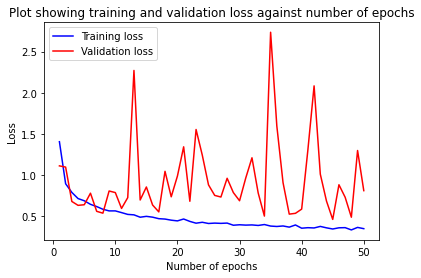

In [13]:
x = range(1, epochs+1)
plt.title("Plot showing training and validation loss against number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.plot(x, loss_train, color='b', label='Training loss')
plt.plot(x, loss_val, color='r', label='Validation loss')
plt.legend()
plt.savefig('results/T2_loss_curves.png', bbox_inches='tight')
plt.show()
# plt.plot()



### Visualize results 

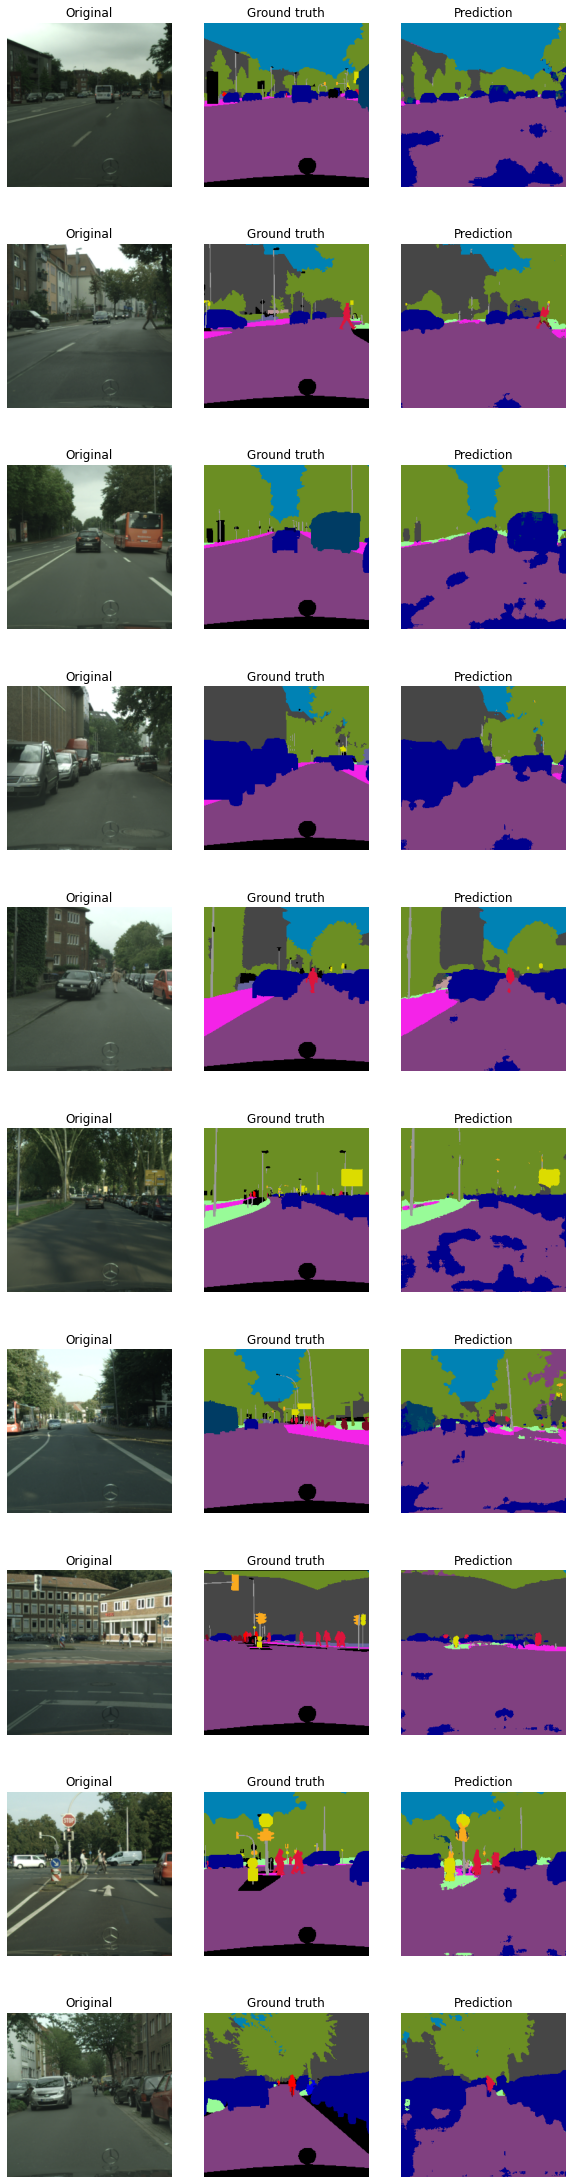

In [10]:
from utils.visual_results import visualize
curr=44
# move model to gpu
model = model.to(device)
# load the model states
model.load_state_dict(torch.load(f'../weights/T2/epoch_{curr}.pth')) # please change 'curr' to the integer value corresponding to weight provided
# perform visualization
visualize(model, val_loader, 'results/T2 results.png', device)

### Evaluation and plotting 


In [16]:
from utils.eval_metrics import evaluation_loop

# #6 evaluation matrices to be used: sensitivity, specificity, accuracy, AUC, DC and IOU
evaluation_loop(model, val_loader, epochs, device, task=2)

Epochs	 Sensitivity-score Specificity-score Accuracy-score ROC-AUC-score	 Dice score	 IOU score
0	 0.794			 0.082		 0.775		 0.615		 0.364		 0.112
1	 0.791			 0.094		 0.779		 0.633		 0.422		 0.129
2	 0.799			 0.116		 0.784		 0.673		 0.488		 0.168
3	 0.771			 0.088		 0.721		 0.696		 0.543		 0.189
4	 0.766			 0.120		 0.698		 0.678		 0.516		 0.175
5	 0.820			 0.260		 0.792		 0.694		 0.497		 0.184
6	 0.788			 0.119		 0.747		 0.702		 0.523		 0.200
7	 0.778			 0.112		 0.757		 0.697		 0.548		 0.198
8	 0.826			 0.129		 0.778		 0.680		 0.517		 0.178
9	 0.787			 0.175		 0.766		 0.688		 0.448		 0.183
10	 0.800			 0.115		 0.774		 0.712		 0.479		 0.205
11	 0.823			 0.192		 0.781		 0.700		 0.464		 0.193
12	 0.425			 0.204		 0.396		 0.615		 0.375		 0.106
13	 0.789			 0.109		 0.765		 0.711		 0.475		 0.199
14	 0.839			 0.229		 0.805		 0.694		 0.445		 0.185
15	 0.785			 0.106		 0.753		 0.703		 0.493		 0.197
16	 0.778			 0.137		 0.749		 0.713		 0.519		 0.210
17	 0.821			 0.116		 0.760		 0.674		 0.430		 0.

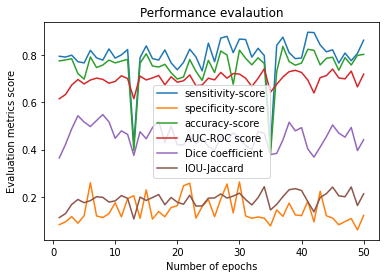

In [12]:
# PLOT
df_r = pd.read_csv('results/T2_eval.csv')

X = range(1, len(df_r)+1)
plt.plot(X, df_r.sensitivity, label="sensitivity-score")
plt.plot(X, df_r.specificity, label="specificity-score")
plt.plot(X, df_r.accuracy, label="accuracy-score")
plt.plot(X, df_r.auc, label="AUC-ROC score")
plt.plot(X, df_r.dice, label="Dice coefficient")
plt.plot(X, df_r.iou, label="IOU-Jaccard")

plt.xlabel("Number of epochs")
plt.ylabel("Evaluation metrics score")
plt.title("Performance evalaution")
plt.legend() # add legend
plt.savefig('results/T2_eval_metrics.png', bbox_inches='tight')
plt.show()